# Sentiment Analysis of Twitter Feeds to Find Your Favorite Airline

Process the raw data and created a final Pandas DataFrame to pass to the Spark application -

In [1]:
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#create a file to contain the 'raw data' from the twitter streaming api
raw_data_path = 'tweets_all@#_7591.json'

#create a list to hold the tweets
raw_data = []

#create and open the new file
tweets_file = open(raw_data_path, "r")

#append to the tweets list from the raw data file
for line in tweets_file:
    try:
        tweet = json.loads(line)
        raw_data.append(tweet)
    except:
        continue       
print "Number of raw data rows - ", len(raw_data)

Number of raw data rows -  7591


In [2]:
tweets = pd.DataFrame()

In [3]:
#removed u'possibly_sensitive', at the moment since not all rows have it
#it goes between place and retweet_count in the below list
twitter_fields = [u'contributors', u'coordinates', u'created_at', u'entities', 
                  u'favorite_count', u'favorited', u'filter_level', u'geo', u'id', 
                  u'id_str', u'in_reply_to_screen_name', u'in_reply_to_status_id', 
                  u'in_reply_to_status_id_str', u'in_reply_to_user_id', u'in_reply_to_user_id_str', 
                  u'lang', u'place',   u'retweet_count', u'retweeted', u'source', 
                  u'text', u'timestamp_ms', u'truncated', u'user']

#set the columns in the dataframe to match the json fields of the twitter streaming api
for t in twitter_fields:
    tweets[t] = map(lambda tweet: tweet[t] if tweet[t] else 'None', raw_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, raw_data)

In [4]:
#View the first 5 tweets of the dataset
pd.set_option('max_colwidth', 200)
tweets['text'].head(5)

0                                                                 I just earned the 'Memorial Day' badge! #TrueBlueBadges https://t.co/QNHxJztYr0
1                    RT @kwilesjrphoto: PHOTO: @BostonFire Marine 1, @BostonLogan ATC tower, and @SouthwestAir taking off https://t.co/k9pNLvHMXy
2    RT PhoebeMONAD Legere JetBlue Media showing baggage handlers playing games with checked bags and cargo! #JetBlue please don't treat #musici…
3                           @delta  Hello it looks like I will not be getting upgraded I keep getting pushed down the list by last minute adds to
4                                                               I just earned the 'Washington, DC' badge! #TrueBlueBadges https://t.co/3eK91cctYJ
Name: text, dtype: object

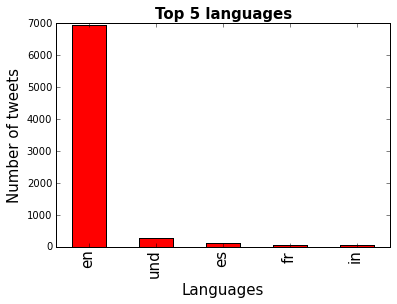

In [5]:
#view the top 5 languages present in the dataset
tweets_by_lang = tweets['lang'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

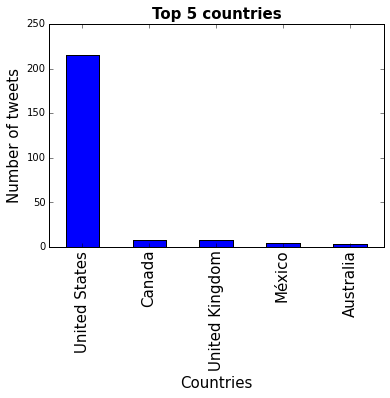

In [6]:
#view the top 5 countries in the dataset
tweets_by_country = tweets['country'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [7]:
import re
#create a function to find the word in the tweet text field
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [8]:
#get the words in the text
airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

#create columns for each airline and set a boolean value to use for the below visualization of tweet count 
#for each airline
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

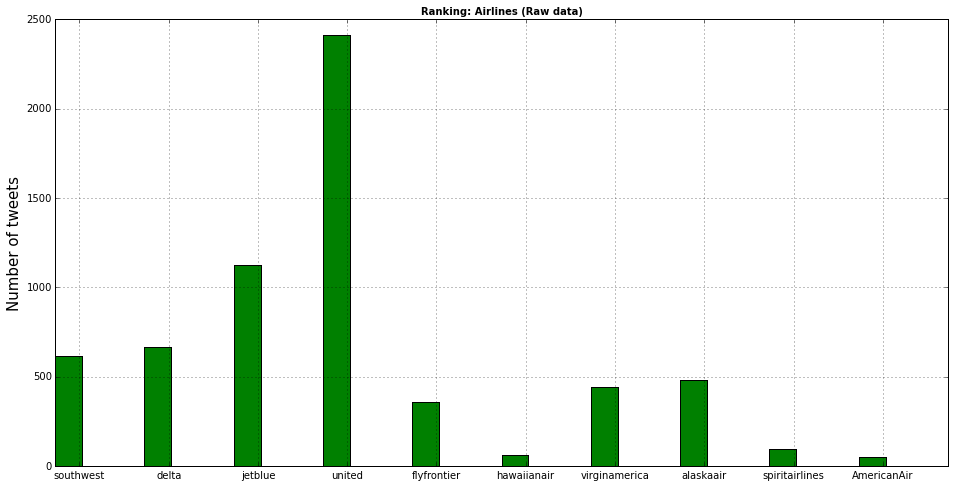

In [9]:
#view the amount of tweets per airline
tweets_by_airlines = [len(tweets.loc[tweets['southwest'] == True]), 
 len(tweets.loc[tweets['delta'] == True]), len(tweets.loc[tweets['jetblue'] == True]),
         len(tweets.loc[tweets['united'] == True]), len(tweets.loc[tweets['flyfrontier'] == True]),
                     len(tweets.loc[tweets['hawaiianair'] == True]),len(tweets.loc[tweets['virginamerica'] == True]),
                     len(tweets.loc[tweets['alaskaair'] == True]),len(tweets.loc[tweets['spiritairlines'] == True]),
                     len(tweets.loc[tweets['AmericanAir'] == True])]

airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

x_pos = list(range(len(airlines)))
width = 0.3
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(x_pos, tweets_by_airlines, width, alpha=1, color='g')
# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Airlines (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.9 * width for p in x_pos])
ax.set_xticklabels(airlines)
plt.grid()

In [10]:
#create a dataframe called 'processed_data' with extra column 'airline'

#a function to set the airline name where the column value is True
def setAirlineName(row):   
    x = None
    for a in airlines:
        if row[a] is True:
            x = a
    if x is not None:
        return x
    else: 
        return

# set a column in the tweets dataframe for each airline name with a boolean value
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

#add the airline column with the airline name as the value 
tweets['airline'] = tweets.apply(lambda row: setAirlineName(row), axis=1)  

#remove the temp. columns for each airline
for a in airlines:
    tweets = tweets.drop(a, 1)

#set the final variable to be passed to the spark process
processed_data = tweets

#processed_data['airline'] values are - 'southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 
# 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir'
print 'The Processed Data File contains', len(processed_data), 'tweets.'

The Processed Data File contains 7591 tweets.


# Pass the proccessed data to spark

In [12]:
import json

import re
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
from gensim import corpora 

In [13]:
import findspark
findspark.init()
print findspark.find()

/usr/local/Cellar/apache-spark/1.5.2/libexec/


In [14]:
import pyspark

In [15]:
# adapted from HW5
def get_parts(thetext, punctuation):
    # generate stopwords list & regexes for 2+ periods or 2+ dashes
    stop = text.ENGLISH_STOP_WORDS
    regex1=re.compile(r"\.{2,}")
    regex2=re.compile(r"\-{2,}")
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [16]:
# initialize Spark context
conf = pyspark.SparkConf().setAppName("Twitter_Airline").setMaster("local[*]")
sc = pyspark.SparkContext(conf=conf)

# get tweets from text file
# using sample tweets for now
#text_lines = sc.textFile('tweets_all@#_7591.json')
#tweets = text_lines.map(json.loads)
#tweets_text = tweets.map(lambda t: t['text'])
tweets_text = sc.parallelize([row['airline'], row['text'] for row in processed_data.iterrows()])



### Sentiment of a sentence based on log probs in a word list

Function to read the word list file:

In [17]:
import numpy as np
# read the word list
def readSentimentList(file_name):
    ifile = open(file_name, 'r')
    happy_log_probs = {}
    sad_log_probs = {}
    ifile.readline() #Ignore title row
    # splitting the csv
    for line in ifile:
        tokens = line[:-1].split(',')
        happy_log_probs[tokens[0]] = float(tokens[1])
        sad_log_probs[tokens[0]] = float(tokens[2])

    return happy_log_probs, sad_log_probs

Using Naive Bayes rule:

In [18]:
def classifySentiment(words, happy_log_probs, sad_log_probs):
    # get the log-probability of each word under each sentiment
    happy_probs = [happy_log_probs[word] for word in words if word in happy_log_probs]
    sad_probs = [sad_log_probs[word] for word in words if word in sad_log_probs]

    # sum all the log-probabilities for each sentiment to get a log-probability for the whole tweet
    tweet_happy_log_prob = np.sum(happy_probs)
    tweet_sad_log_prob = np.sum(sad_probs)

    # calculate the probability of the tweet belonging to each sentiment
    prob_happy = np.reciprocal(np.exp(tweet_sad_log_prob - tweet_happy_log_prob) + 1)
    prob_sad = 1 - prob_happy

    return prob_happy, prob_sad

Load the word list:

In [19]:
# load list of words and log probs
happy_log_probs, sad_log_probs = readSentimentList('wordlist.csv')

Reading in the tweet:

In [20]:
# read tweet
tweet1 = ['my', 'hate', 'southwest']

# calculate the probability
tweet1_happy_prob, tweet1_sad_prob = classifySentiment(tweet1, happy_log_probs, sad_log_probs)

print tweet1 
print "happy probability: " , tweet1_happy_prob 
print "sad probability:", tweet1_sad_prob

['my', 'hate', 'southwest']
happy probability:  0.280105168408
sad probability: 0.719894831592


In [21]:
# get words out for sentiment analysis
punc = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
sentiment_words = tweets_text.mapValues(lambda t: t.strip(punc).split())

# classify sentiment of tweet
tweets_probs = sentiment_words.mapValues(lambda ws: classifySentiment(ws, happy_log_probs, sad_log_probs))
happy_probs = tweets_probs.mapValues(lambda (hprob, sprob): hprob)
sad_probs = tweets_probs.mapValues(lambda (hprob, sprob): sprob)


### LDA on nouns for topic analysis

In [22]:
# parse tweets to nouns & adjectives
tweets_n_a = tweets_text.map(lambda a,t: get_parts(t, punc))
tweets_nouns = tweets_n_a.keys()
all_nouns = tweets_nouns.flatMap(lambda l: l).toLocalIterator()
tweets_adjs = tweets_n_a.values()

# feed nouns into gensim
dictionary = corpora.Dictionary(all_nouns)